In [3]:
inference_forecast_model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Testing the model: context 512 prediction 96
## (This pre-trained model has config of a fixed 512 context window: https://huggingface.co/ibm-granite/granite-timeseries-patchtst)

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Full Period Metrics:
MAE: 260.3112
MSE: 95083.9116
RMSE: 308.3568
MAPE: 4.4717
SMAPE: 4.5625
MASE: 8.0819


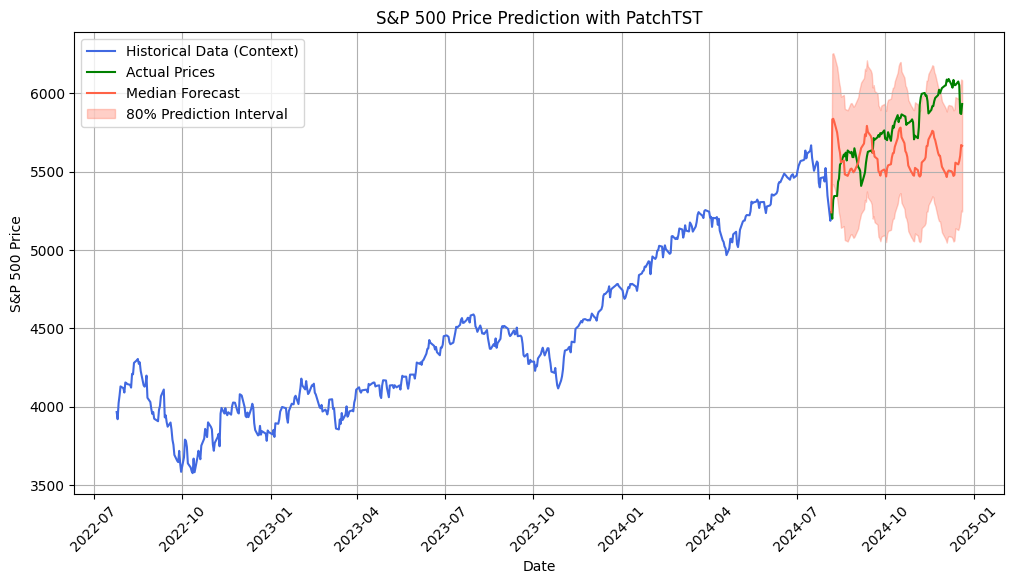


COVID Period Metrics:
MAE: 352.7437
MSE: 156585.8928
RMSE: 395.7094
MAPE: 7.6604
SMAPE: 8.0362
MASE: 10.0258


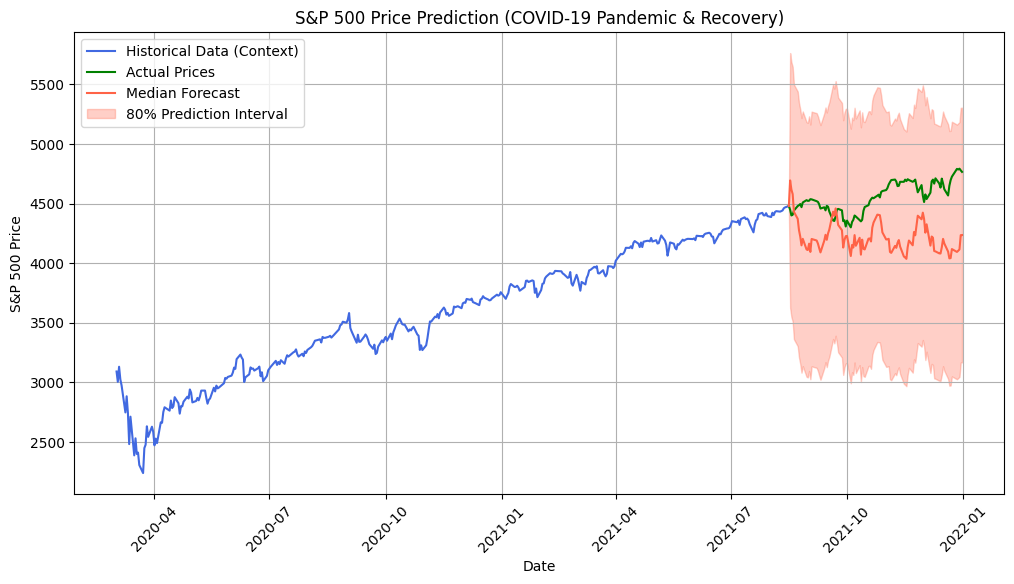

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import PatchTSTForPrediction

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 512
PREDICTION_WINDOW = 96

# Initialize model with pre-trained weights
model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]

def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    if len(context) < CONTEXT_WINDOW:
        padding = CONTEXT_WINDOW - len(context)
        context = np.pad(context, (padding, 0), mode='constant', constant_values=0)

    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    forecast_std = np.std(context) * 0.5
    median = predictions
    low = predictions - 1.28 * forecast_std
    high = predictions + 1.28 * forecast_std

    return low, median, high


def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,  # Convert to percentage
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with PatchTST",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Running daily frequency experiments...


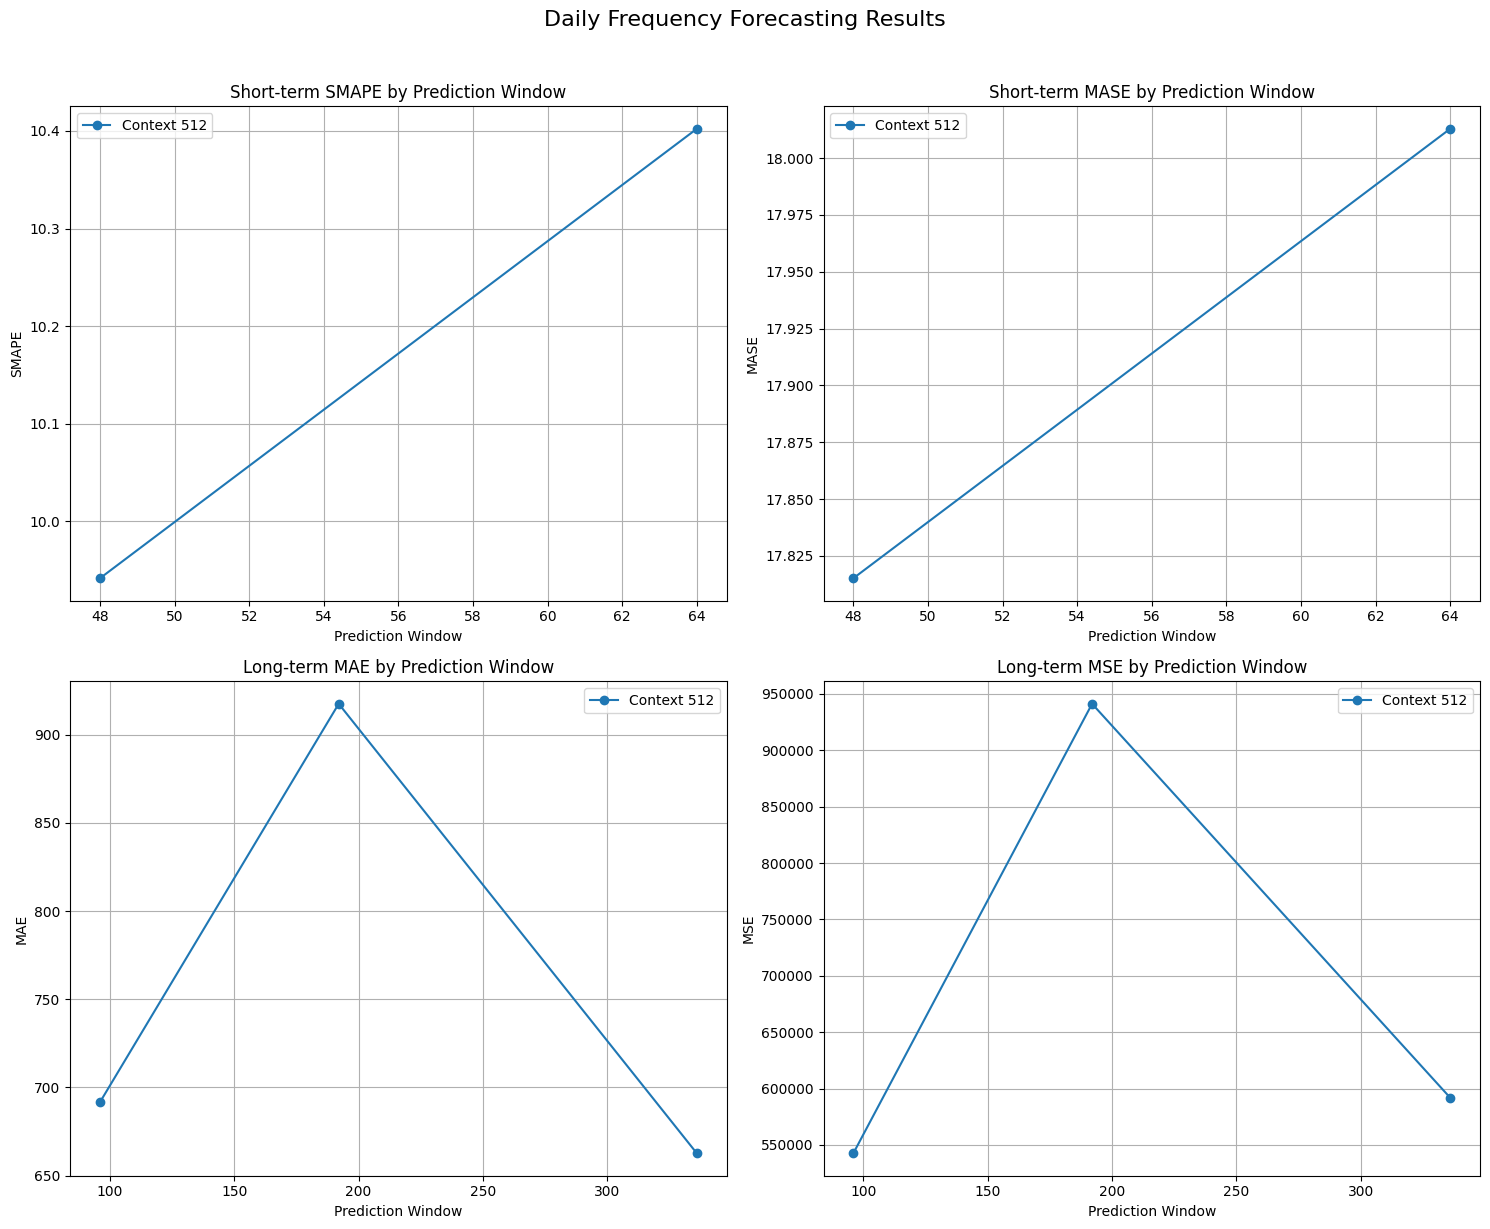


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE     MASE          MSE  \
Context Window Prediction Window                                           
512            48                 561.5250  9.4301  17.8152  345414.3536   
               64                 581.7984  9.8395  18.0129  373613.0140   

Metric                                RMSE    SMAPE  
Context Window Prediction Window                     
512            48                 587.7196   9.9415  
               64                 611.2389  10.4022  

Long-term Forecasting Results:
Metric                                 MAE     MAPE     MASE          MSE  \
Context Window Prediction Window                                            
512            96                 691.6615  11.8582  21.4740  542642.0761   
               192                917.5378  16.3066  25.4750  941170.7803   
               336                662.6778  12.2309  17.2939  591907.9990   

Me

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


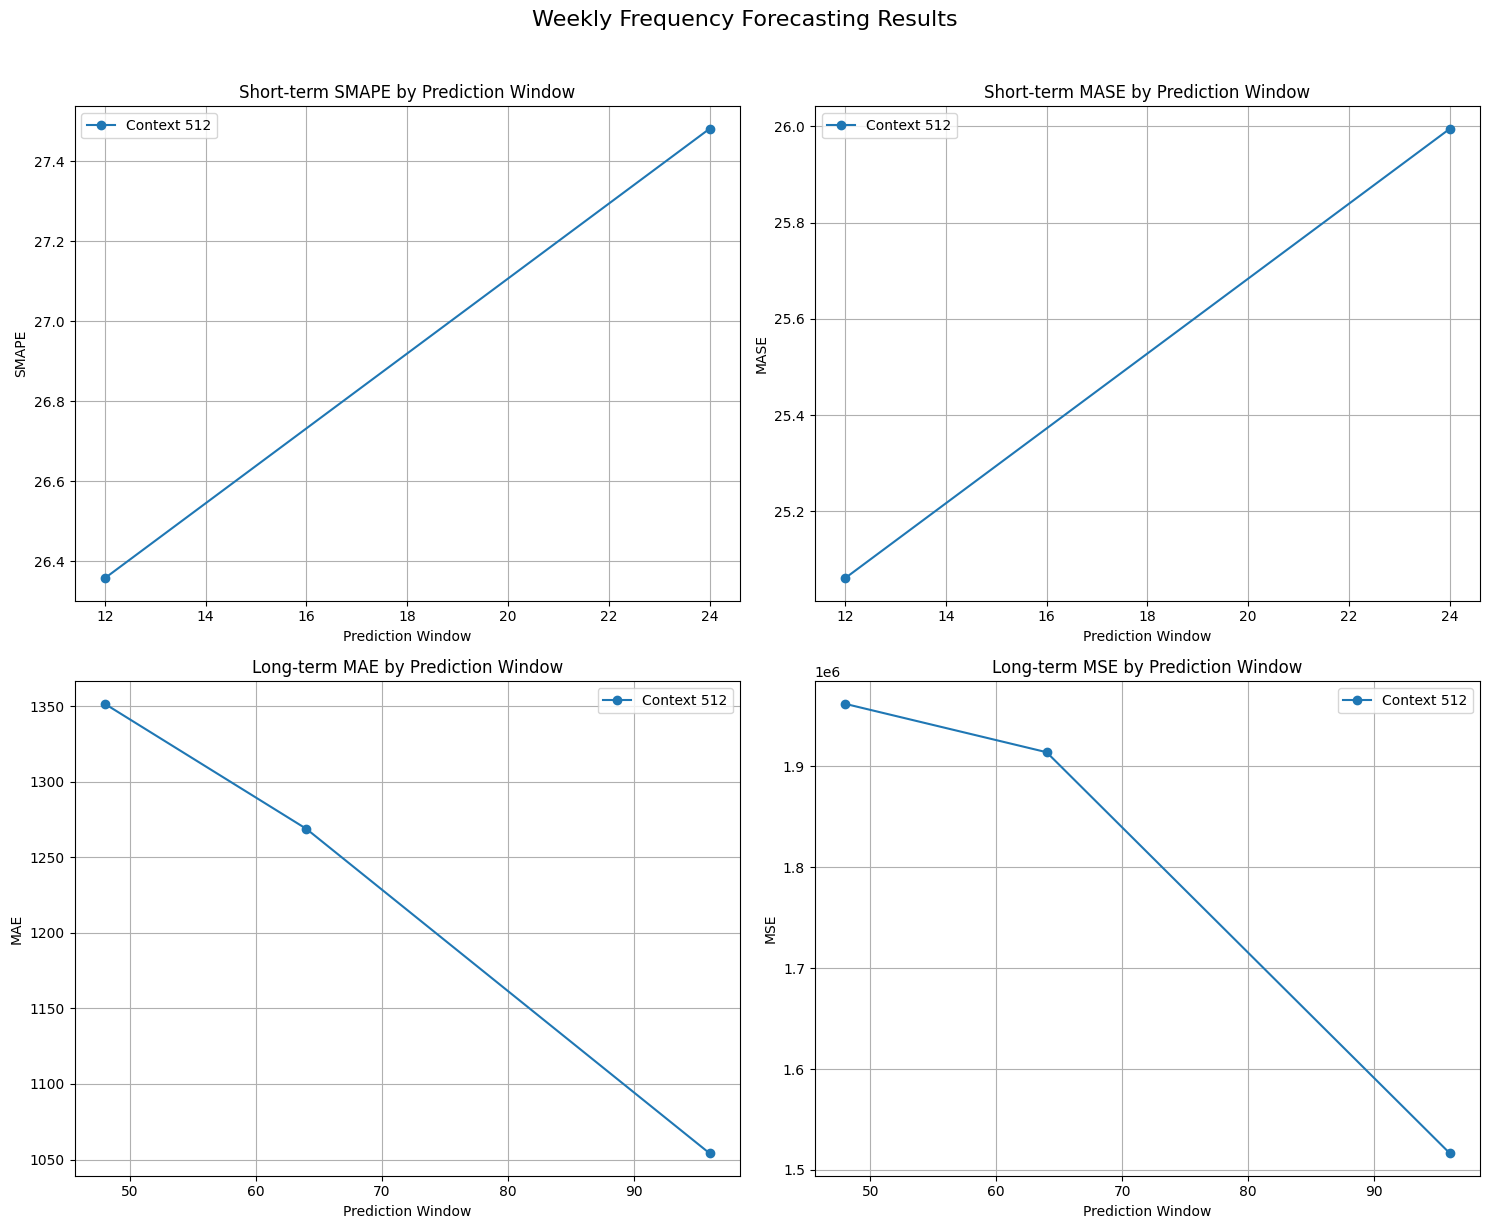


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
512            12                 1373.5158  23.1630  25.0611  1.978221e+06   
               24                 1383.5998  23.9986  25.9951  2.032498e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
512            12                 1406.4923  26.3581  
               24                 1425.6570  27.4814  

Long-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
512            48                 1351.6155  24.4542  26.3393  1.962130e+06   
               64                 1268.8600  23.4435  25.4967  1.914130e+06   
               96                 1054.1477  20.2205  2

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


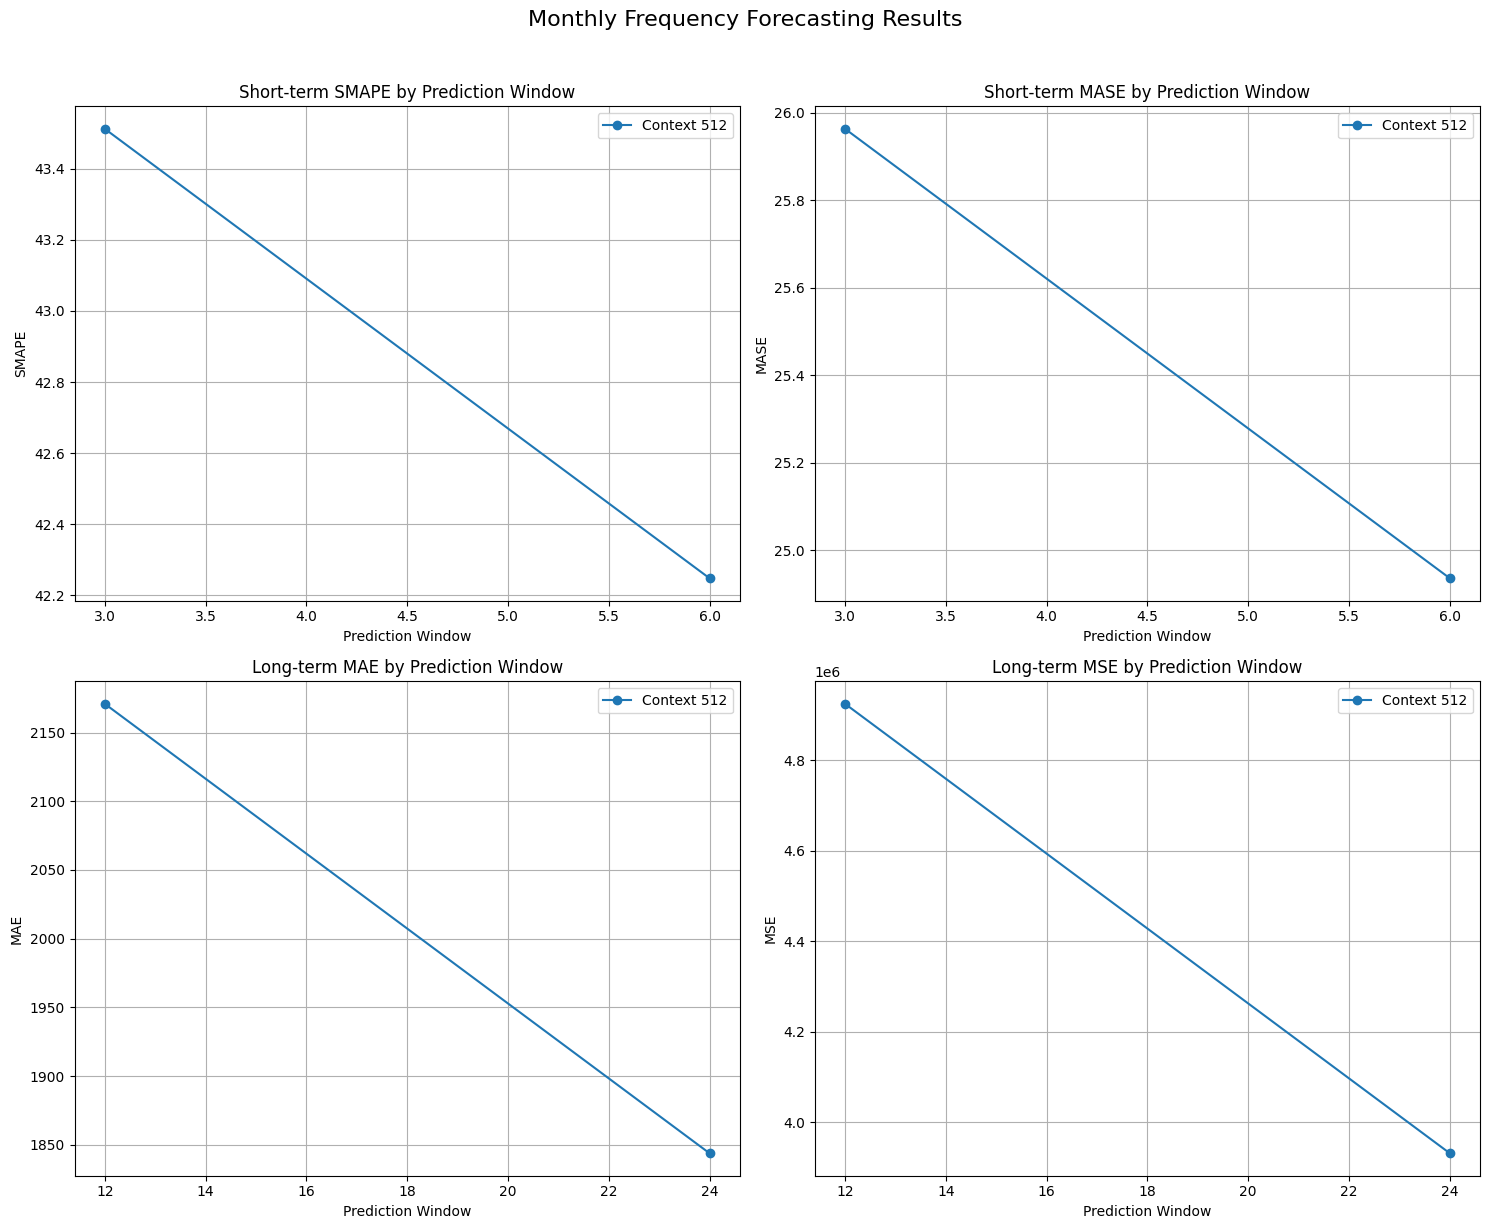


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
512            3                  2099.8489  35.7263  25.9632  4.424709e+06   
               6                  2010.3772  34.8524  24.9359  4.073827e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
512            3                  2103.4993  43.5125  
               6                  2018.3723  42.2481  

Long-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
512            12                 2170.8976  39.3799  27.9139  4.925317e+06   
               24                 1843.9261  36.4093  25.2257  3.931567e+06   

Metric                                 RMSE    SMAPE 

In [6]:
import numpy as np
import torch
from transformers import PatchTSTForPrediction
from dataclasses import dataclass
from utils.evaluate import ContextPredictionWindowEvaluator
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.visualization import plot_results_by_frequency

# Pre-trained PatchTST model
model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")


# Forecast Function
def patchtst_forecast(model, context, prediction_window):
    """Generate forecast using PatchTST with dynamic prediction length"""
    # Ensure the model is dynamically reconfigured
    if model is None:
        model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")
        model.config.prediction_length = prediction_window  # Dynamically set prediction length

    context = np.asarray(context).flatten()

    # Ensure context matches the required size
    if len(context) < 512:
        context = np.pad(context, (512 - len(context), 0), mode="constant", constant_values=0)

    # Normalize
    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # Create tensor and replicate channels
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # Extract predictions and denormalize
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    # Adjust predictions to match the prediction_window length
    if len(predictions) > prediction_window:
        predictions = predictions[:prediction_window]
    elif len(predictions) < prediction_window:
        predictions = np.pad(predictions, (0, prediction_window - len(predictions)), mode="constant", constant_values=0)

    # Prediction intervals
    forecast_std = np.std(context) * 0.5
    low = predictions - 1.28 * forecast_std
    median = predictions
    high = predictions + 1.28 * forecast_std

    # Validate prediction length
    assert len(median) == prediction_window, (
        f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"
    )

    return low, median, high



@dataclass
class PatchTSTExperimentConfig:
    """Experiment configuration for PatchTST"""

    daily_config = {
        "context_windows": [512],
        "short_term_windows": [48, 64],
        "long_term_windows": [96, 192, 336],
    }

    weekly_config = {
        "context_windows": [512],
        "short_term_windows": [12, 24],
        "long_term_windows": [48, 64, 96],
    }

    monthly_config = {
        "context_windows": [512],
        "short_term_windows": [3, 6],
        "long_term_windows": [12, 24],
    }


# Unified Evaluator
dummy_model = None  # Placeholder for dynamic model initialization

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=patchtst_forecast, config=PatchTSTExperimentConfig()
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")

    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)


# Visualizing the best performing results for long and short-term forecasting at different frequencies for recent and COVID periods

Generating plots for extended period...


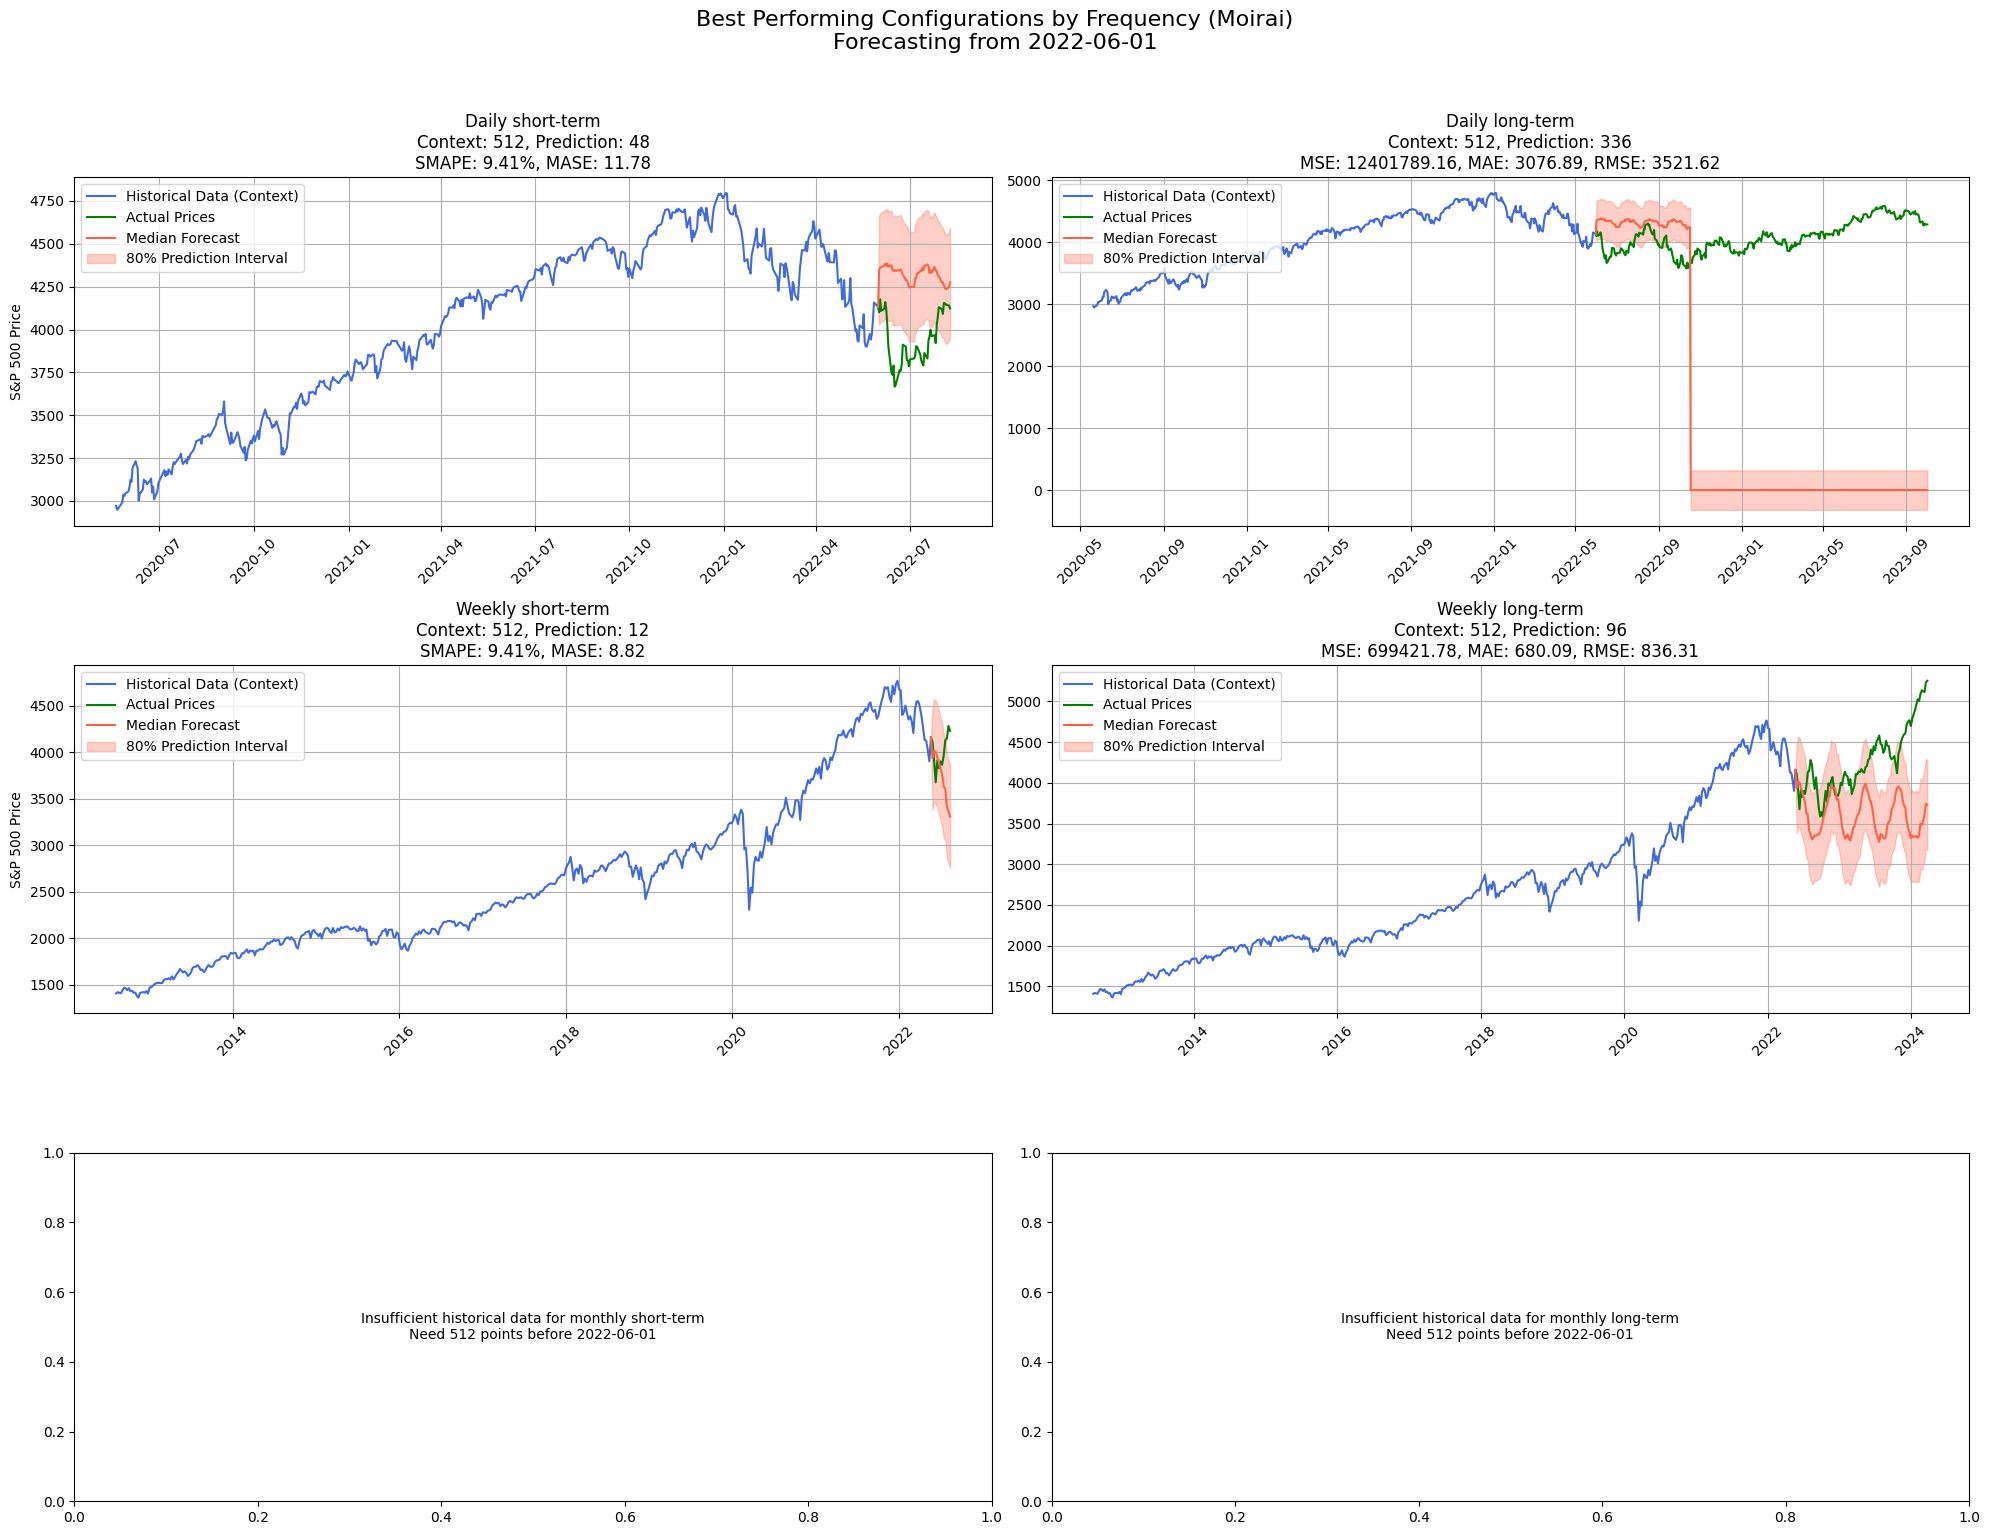


Generating plots for COVID period...


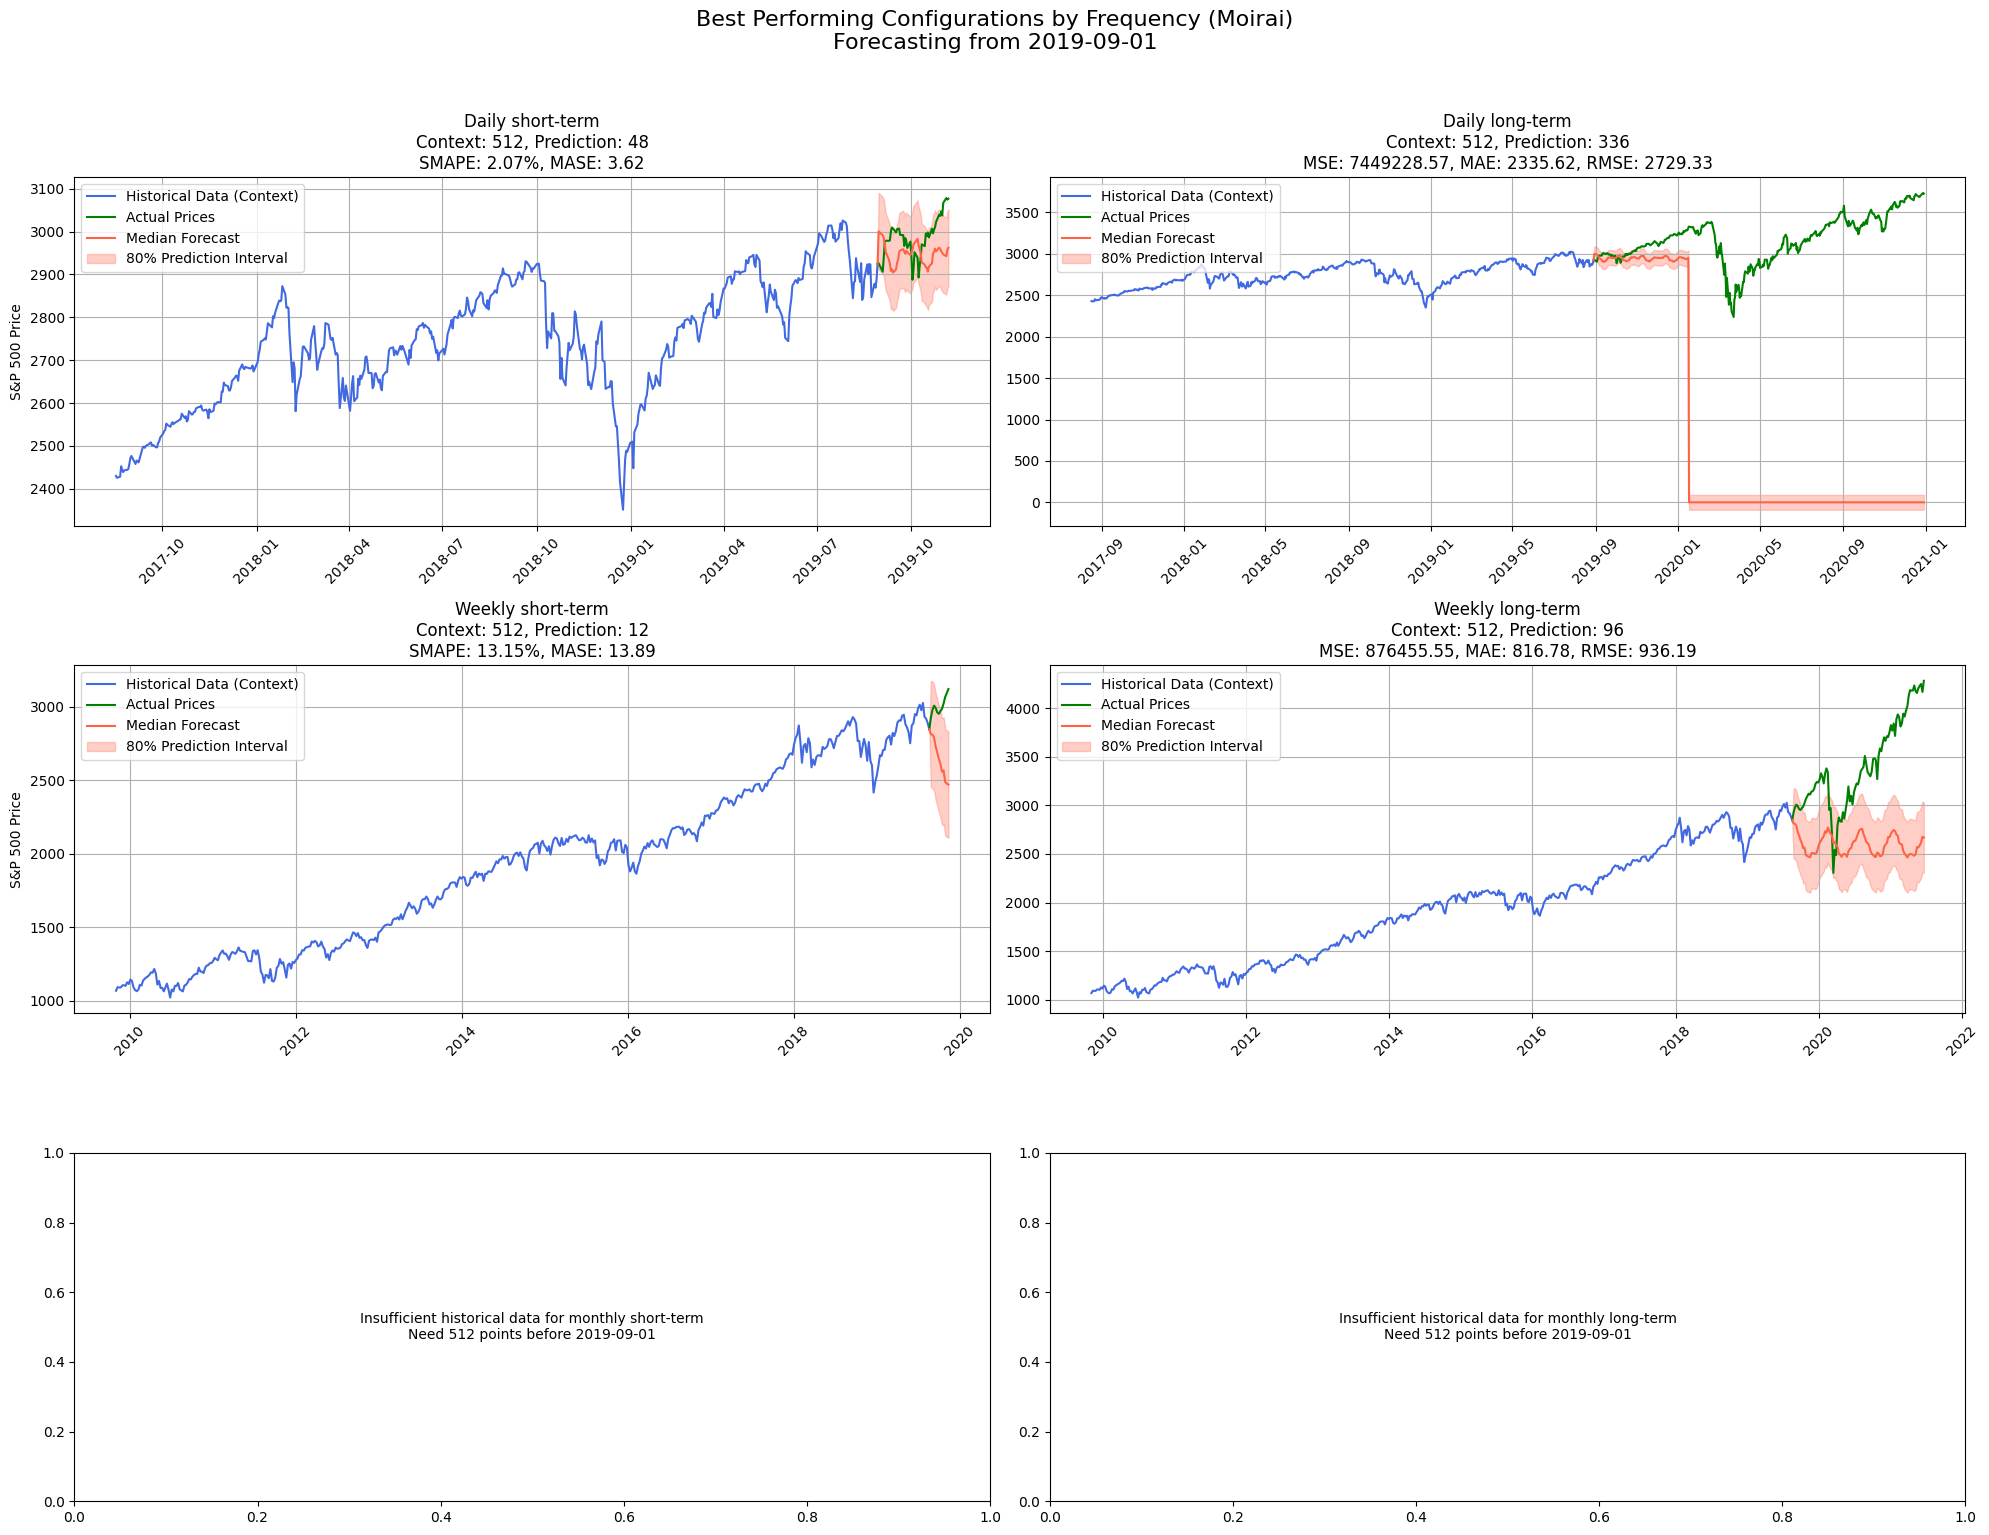


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 512.0000
prediction: 48.0000
MAE: 61.5274
MSE: 4774.6692
RMSE: 69.0990
MAPE: 2.0519
SMAPE: 2.0704
MASE: 3.6215

COVID Period (forecast from 2021-03-01):
context: 512.0000
prediction: 48.0000
MAE: 61.5274
MSE: 4774.6692
RMSE: 69.0990
MAPE: 2.0519
SMAPE: 2.0704
MASE: 3.6215

Long-term metrics:
Extended Period (forecast from 2024-01-01):
context: 512.0000
prediction: 336.0000
MAE: 2335.6195
MSE: 7449228.5666
RMSE: 2729.3275
MAPE: 72.7587
SMAPE: 144.2325
MASE: 137.4740

COVID Period (forecast from 2021-03-01):
context: 512.0000
prediction: 336.0000
MAE: 2335.6195
MSE: 7449228.5666
RMSE: 2729.3275
MAPE: 72.7587
SMAPE: 144.2325
MASE: 137.4740

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 512.0000
prediction: 12.0000
MAE: 368.8476
MSE: 165112.2546
RMSE: 406.3401
MAPE: 12.1799
SMAPE: 13.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import PatchTSTForPrediction
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import calculate_metrics
from utils.visualization import plot_best_configs


def generate_patchtst_forecast(context, prediction_window):
    """Generate forecast using PatchTST model"""
    # Load the pre-trained model
    model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")

    context = np.asarray(context).flatten()

    # Ensure context matches the required size
    if len(context) < 512:
        context = np.pad(context, (512 - len(context), 0), mode="constant", constant_values=0)

    # Normalize
    mean = np.mean(context)
    std = np.std(context)
    context_normalized = (context - mean) / std

    # Create tensor and replicate channels
    context_tensor = torch.tensor(context_normalized).float().unsqueeze(0).unsqueeze(-1)
    context_tensor = context_tensor.repeat(1, 1, 7)

    with torch.no_grad():
        outputs = model(past_values=context_tensor)

    # Extract predictions and denormalize
    predictions = outputs.prediction_outputs.squeeze().numpy()[:, 0]
    predictions = predictions * std + mean

    # Adjust predictions to match the prediction_window length
    if len(predictions) > prediction_window:
        predictions = predictions[:prediction_window]
    elif len(predictions) < prediction_window:
        predictions = np.pad(predictions, (0, prediction_window - len(predictions)), mode="constant", constant_values=0)

    # Prediction intervals
    forecast_std = np.std(context) * 0.5
    low = predictions - 1.28 * forecast_std
    median = predictions
    high = predictions + 1.28 * forecast_std

    return low, median, high


def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """
    Plot best performing configurations for each frequency

    Args:
        data_dict: Dictionary with frequency as key and DataFrame as value
        configs_dict: Dictionary with configurations
        forecast_point: The date from which to start forecasting
        time_period: Tuple of (start_date, end_date) for data selection
    """
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(
        f"Best Performing Configurations by Frequency (Moirai)\nForecasting from {forecast_point}",
        fontsize=16,
        y=1.02,
    )

    plot_idx = 1

    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()

        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()

        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])

        # Filter data for the specified period
        period_data = data[
            (data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])
        ].reset_index(drop=True)

        # Find the forecast start point
        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[
            -1
        ]

        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)

            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]

            # Check if we have enough data before forecast point
            if forecast_start_idx < context_window:
                ax.text(
                    0.5,
                    0.5,
                    f"Insufficient historical data for {freq} {term}-term\n"
                    f"Need {context_window} points before {forecast_point}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Get data windows relative to forecast point
            window_start = forecast_start_idx - context_window
            window_end = min(
                forecast_start_idx + prediction_window + 1, len(period_data)
            )
            window_data = period_data.iloc[window_start:window_end].copy()

            # Verify we have enough data
            if len(window_data) < context_window + prediction_window:
                ax.text(
                    0.5,
                    0.5,
                    f"Insufficient data for full prediction window\n"
                    f"Need {context_window + prediction_window} points, have {len(window_data)}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Generate forecast
            context = window_data["Close"].values[:context_window]
            low, median, high = generate_patchtst_forecast(context, prediction_window)

            # Calculate metrics
            actual_values = window_data["Close"].values[
                context_window : context_window + prediction_window
            ]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)

            configs_dict[freq][term].update(metrics)

            # Prepare plotting data
            last_context_point = window_data["Close"].iloc[context_window - 1]

            # Ensure all arrays have the same length (prediction_window + 1 for the last context point)
            plot_actual = np.insert(
                actual_values[:prediction_window], 0, last_context_point
            )
            plot_median = np.insert(median[:prediction_window], 0, last_context_point)
            plot_low = np.insert(low[:prediction_window], 0, last_context_point)
            plot_high = np.insert(high[:prediction_window], 0, last_context_point)

            # Get corresponding dates
            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[
                context_window - 1 : context_window + prediction_window
            ]

            # Ensure all arrays have matching lengths
            assert len(forecast_dates) == len(
                plot_median
            ), f"Length mismatch: dates={len(forecast_dates)}, forecast={len(plot_median)}"

            # Plot
            ax.plot(
                historical_dates,
                window_data["Close"].iloc[:context_window],
                color="royalblue",
                label="Historical Data (Context)",
            )
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(
                forecast_dates, plot_median, color="tomato", label="Median Forecast"
            )
            ax.fill_between(
                forecast_dates,
                plot_low,
                plot_high,
                color="tomato",
                alpha=0.3,
                label="80% Prediction Interval",
            )

            if term == "short":
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}'
                )
            else:
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}'
                )

            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")

            plot_idx += 1

    plt.tight_layout()
    plt.show()

    return configs_dict


# Define configurations
configs_dict = {
    "daily": {
        "short": {"context": 512, "prediction": 48},
        "long": {"context": 512, "prediction": 336},
    },
    "weekly": {
        "short": {"context": 512, "prediction": 12},
        "long": {"context": 512, "prediction": 96},
    },
    "monthly": {
        "short": {"context": 512, "prediction": 6},
        "long": {"context": 512, "prediction": 24},
    },
}

# Create data dictionary
data_dict = {"daily": snp500_daily, "weekly": snp500_weekly, "monthly": snp500_monthly}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2022-06-01",  # Fixed forecast point for extended period
    time_period=("1970-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2019-09-01",  # Fixed forecast point during COVID
    time_period=("1970-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2024-01-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")

        print("\nCOVID Period (forecast from 2021-03-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")


In [9]:
import yfinance as yf

ticker = yf.Ticker("^GSPC")
history = ticker.history(period="max")

earliest_date = history.index.min()
earliest_date

Timestamp('1927-12-30 00:00:00-0500', tz='America/New_York')

In [13]:
from data.snp500 import snp500_monthly
len(snp500_monthly)

239

## didn't have enough data for monthly frequency for a 512 context window, but i dont think it really makes sense to look that far back anyways (~40 years)